# **Klasyfikacja zdarzeń drogowych w mieście Wrocław**

Dane do projektu zostały pobrane ze strony https://sewik.pl/ za pomocą makra stworzonego w Excelu.
Celem projektu była analiza danych dotyczących zdarzeń drogowych w mieście Wrocław w latach 2020-2022 oraz stworzenie modelu przewidującego, czy dane zdarzenie jest kolizją czy wypadkiem.

Do projektu wykorzystano również poniższe pliki pochodzące ze strony http://www.geoportal.wroclaw.pl/zasoby/
- Granice osiedli Wrocławia: Mapa granic osiedli Wrocławia do pobrania w formie spakowanego (zip) pliku shp
- Ewidencja miejscowości ulic i adresów: Adresy.zip

## **Import danych oraz bibliotek**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
df = pd.read_excel('projekt_dane.xlsx')
df.head()

Id                                              Adres  \
0  108523227.0                                    WROCŁAW TYLNA 5   
1  108526505.0  WROCŁAW TRZEBNICKA 24 / KAZIMIERZA JAGIELLOŃCZYKA   
2  108526705.0                          WROCŁAW STANISŁAWOWSKA 57   
3  108526863.0  WROCŁAW JEDNOŚCI NARODOWEJ 207 / KARD. STEFANA...   
4  108526874.0                WROCŁAW ALEJA JANA KOCHANOWSKIEGO 1   

  Miejsce zdarzenia                     Rodzaj zdarzenia      Data zdarzenia  \
0           Jezdnia  Najechanie na pojazd unieruchomiony 2020-01-02 09:14:00   
1           Jezdnia             Zderzenie pojazdów tylne 2020-01-01 04:13:00   
2           Jezdnia               Najechanie na pieszego 2020-01-01 08:53:00   
3           Jezdnia             Zderzenie pojazdów tylne 2020-01-01 20:25:00   
4           Jezdnia            Zderzenie pojazdów boczne 2020-01-01 18:05:00   

  Współrzędne geograficzne             Warunki pogodowe    Obrażenia  
0     17*06'475, 51*08'439  Dobre warunki atmosferyczne         Brak  
1     17*01'156, 51*04'193  Dobre warunki atmosferyczne         Brak  
2     16*56'489, 51*05'489  Dobre warunki atmosferyczne  Ranny lekko  
3     17*03'153, 51*07'413                    Pochmurno         Brak  
4       17*03'40, 51*06'59  Dobre warunki atmosferyczne         Brak

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31420 entries, 0 to 31419
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        31419 non-null  float64       
 1   Adres                     31420 non-null  object        
 2   Miejsce zdarzenia         31420 non-null  object        
 3   Rodzaj zdarzenia          31420 non-null  object        
 4   Data zdarzenia            31420 non-null  datetime64[ns]
 5   Współrzędne geograficzne  31420 non-null  object        
 6   Warunki pogodowe          31420 non-null  object        
 7   Obrażenia                 31420 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 1.9+ MB


## **Czyszczenie danych**

In [5]:
df[['Długość geograficzna','Szerokość geograficzna']] = df['Współrzędne geograficzne'].str.split(',', expand=True)
df[['Długość geograficzna stopnie','Długość geograficzna min i sek']] = df['Długość geograficzna'].str.split('*', expand=True)
df[['Szerokość geograficzna stopnie','Szerokość geograficzna min i sek']] = df['Szerokość geograficzna'].str.split('*', expand=True)

In [6]:
df[['Długość geograficzna min','Długość geograficzna sek']] = df['Długość geograficzna min i sek'].str.split("'", n=1, expand=True)
df[['Szerokość geograficzna min','Szerokość geograficzna sek']] = df['Szerokość geograficzna min i sek'].str.split("'", n=1, expand=True)

In [7]:
df.drop(columns=['Długość geograficzna min i sek','Długość geograficzna', 'Szerokość geograficzna min i sek', 'Szerokość geograficzna'], inplace=True)

In [8]:
df['Długość geograficzna sek'] = df['Długość geograficzna sek'].str.replace("'",'', regex=True)
df['Szerokość geograficzna sek'] = df['Szerokość geograficzna sek'].str.replace("'",'', regex=True)

In [9]:
df2 = df[['Długość geograficzna stopnie', 'Długość geograficzna min', 'Długość geograficzna sek', 'Szerokość geograficzna stopnie', 'Szerokość geograficzna min','Szerokość geograficzna sek' ]].astype(np.int64)

In [10]:
df2[['Długość geograficzna min','Szerokość geograficzna min']]= df2[['Długość geograficzna min','Szerokość geograficzna min']].div(60).round(5)
df2[['Długość geograficzna sek', 'Szerokość geograficzna sek']]= df2[['Długość geograficzna sek', 'Szerokość geograficzna sek']].div(36000).round(5)

In [11]:
df2['Długość geograficzna'] = df2['Długość geograficzna stopnie']+df2['Długość geograficzna min']+df2['Długość geograficzna sek']
df2['Szerokość geograficzna'] = df2['Szerokość geograficzna stopnie']+df2['Szerokość geograficzna min']+df2['Szerokość geograficzna sek']

In [12]:
df.drop(df.iloc[:,8:14], axis=1, inplace=True)

In [13]:
df = pd.concat([df, df2[['Długość geograficzna','Szerokość geograficzna']]], axis=1, join="inner")

In [14]:
df['Godzina'] = df['Data zdarzenia'].apply(lambda time: time.hour)
df['Miesiąc'] = df['Data zdarzenia'].apply(lambda time: time.month)
df['Rok'] = df['Data zdarzenia'].apply(lambda time: time.year)
df['Dzień tygodnia'] = df['Data zdarzenia'].apply(lambda time: time.dayofweek)
dmap = {0:'Poniedziałek',1:'Wtorek',2:'Środa',3:'Czwartek',4:'Piątek',5:'Sobota',6:'Niedziela'}
df['Dzień tygodnia'] = df['Dzień tygodnia'].map(dmap)

In [15]:
df

Id                                              Adres  \
0      108523227.0                                    WROCŁAW TYLNA 5   
1      108526505.0  WROCŁAW TRZEBNICKA 24 / KAZIMIERZA JAGIELLOŃCZYKA   
2      108526705.0                          WROCŁAW STANISŁAWOWSKA 57   
3      108526863.0  WROCŁAW JEDNOŚCI NARODOWEJ 207 / KARD. STEFANA...   
4      108526874.0                WROCŁAW ALEJA JANA KOCHANOWSKIEGO 1   
...            ...                                                ...   
31415  124670402.0               WROCŁAW ALEJA GEN. JÓZEFA HALLERA 86   
31416  124674410.0               WROCŁAW ALEJA GEN. JÓZEFA HALLERA 52   
31417  124675487.0                                   WROCŁAW DŁUGA 29   
31418  124689432.0                 WROCŁAW PLAC POWSTAŃCÓW ŚLĄSKICH 7   
31419  124689441.0                      WROCŁAW BOLESŁAWA CHROBREGO 1   

        Miejsce zdarzenia                     Rodzaj zdarzenia  \
0                 Jezdnia  Najechanie na pojazd unieruchomiony   
1                 Jezdnia             Zderzenie pojazdów tylne   
2                 Jezdnia               Najechanie na pieszego   
3                 Jezdnia             Zderzenie pojazdów tylne   
4                 Jezdnia            Zderzenie pojazdów boczne   
...                   ...                                  ...   
31415  Parking, plac, MOP  Najechanie na pojazd unieruchomiony   
31416  Parking, plac, MOP  Najechanie na pojazd unieruchomiony   
31417  Parking, plac, MOP  Najechanie na pojazd unieruchomiony   
31418             Jezdnia  Najechanie na pojazd unieruchomiony   
31419             Pobocze             Najechanie na słup, znak   

           Data zdarzenia Współrzędne geograficzne  \
0     2020-01-02 09:14:00     17*06'475, 51*08'439   
1     2020-01-01 04:13:00     17*01'156, 51*04'193   
2     2020-01-01 08:53:00     16*56'489, 51*05'489   
3     2020-01-01 20:25:00     17*03'153, 51*07'413   
4     2020-01-01 18:05:00       17*03'40, 51*06'59   
...                   ...                      ...   
31415 2022-12-29 14:20:00     16*59'400, 51*05'241   
31416 2022-12-17 12:20:00     16*59'424, 51*05'245   
31417 2022-12-20 13:30:00     17*00'538, 51*07'117   
31418 2022-12-05 15:30:00     17*00'551, 51*05'278   
31419 2022-12-23 11:16:00     17*02'077, 51*07'151   

                  Warunki pogodowe    Obrażenia  Długość geograficzna  \
0      Dobre warunki atmosferyczne         Brak              17.11319   
1      Dobre warunki atmosferyczne         Brak              17.02100   
2      Dobre warunki atmosferyczne  Ranny lekko              16.94691   
3                        Pochmurno         Brak              17.05425   
4      Dobre warunki atmosferyczne         Brak              17.05111   
...                            ...          ...                   ...   
31415  Dobre warunki atmosferyczne         Brak              16.99444   
31416  Dobre warunki atmosferyczne         Brak              16.99511   
31417  Dobre warunki atmosferyczne         Brak              17.01494   
31418  Dobre warunki atmosferyczne         Brak              17.01531   
31419  Dobre warunki atmosferyczne         Brak              17.03547   

       Szerokość geograficzna  Godzina  Miesiąc   Rok Dzień tygodnia  
0                    51.14552        9        1  2020       Czwartek  
1                    51.07203        4        1  2020          Środa  
2                    51.09691        8        1  2020          Środa  
3                    51.12814       20        1  2020          Środa  
4                    51.10164       18        1  2020          Środa  
...                       ...      ...      ...   ...            ...  
31415                51.09002       14       12  2022       Czwartek  
31416                51.09014       12       12  2022         Sobota  
31417                51.11992       13       12  2022         Wtorek  
31418                51.09105       15       12  2022   Poniedziałek  
31419                51.12086       11 

In [16]:
df[['Ulica1','Ulica2']] = df['Adres'].str.split(" / ",n=1, expand=True)
df[['Miasto','Ulica1']] = df['Ulica1'].str.split(" ",n=1, expand=True)

In [17]:
df['Ulica1'] = df['Ulica1'].str.strip()
df['Ulica1'] = df['Ulica1'].str.split('(\d+)',n=1, expand=True, regex=True)[0]

In [18]:
df = df.fillna(value=np.nan)
df['Ulica1'] = df['Ulica1'].fillna(df['Ulica2'])
df['Ulica1'] = df['Ulica1'].str.strip()

Import danych adresowych Wrocławia w celu dopasowania nazw osiedli do danych projektowych na podstawie nazw ulic.

In [19]:
dfos = pd.read_excel('dzielnice wroc.xlsx')
dfos.head()

LOKALNYID ULICA_LOKALNYID ULICA_NAZWA NUMER_ADR KOD_POCZTOWY  \
0  pa_32869         ul_1742  ul. 3 Maja        11       52-119   
1  pa_47201         ul_1742  ul. 3 Maja        12       52-119   
2  pa_34880         ul_1742  ul. 3 Maja        13       52-119   
3  pa_51240         ul_1742  ul. 3 Maja       13d       52-119   
4  pa_39299         ul_1742  ul. 3 Maja        1b       52-119   

  ETYKIETA_NAZWA_SKROCONA GUS_TERC_DELEGATURA RMWROC_OSIEDLE  
0               3 Maja 11      Wrocław-Krzyki        Brochów  
1               3 Maja 12      Wrocław-Krzyki        Brochów  
2               3 Maja 13      Wrocław-Krzyki        Brochów  
3              3 Maja 13d      Wrocław-Krzyki        Brochów  
4               3 Maja 1b      Wrocław-Krzyki        Brochów

In [20]:
dfos['ULICA_NAZWA'] = dfos['ULICA_NAZWA'].str.upper()
dfos.rename(columns={'ULICA_NAZWA':'Ulica1','RMWROC_OSIEDLE':'Osiedle'}, inplace = True)  
dfos["Ulica1"] = dfos["Ulica1"].str.rsplit('ul. ', n=1, expand=True)

In [21]:
dfos['Ulica1'] = dfos['Ulica1'].str.replace("UL. ",'', regex=True)

In [22]:
df2 = dfos[['Ulica1', 'Osiedle']]
df2 = df2.drop_duplicates(subset='Ulica1')

In [23]:
df['Ulica1'] = df['Ulica1'].str.replace("PLAC",'PL.', regex=True)
df['Ulica1'] = df['Ulica1'].str.replace("ALEJA",'AL.', regex=True)
df['Ulica1'] = df['Ulica1'].str.replace("AL. ALEKSANDRA BRUCKNERA", "AL. ALEKSANDRA BRÜCKNERA",regex=True)

In [24]:
df3 = pd.merge(df, df2, on ='Ulica1', how ='left')

In [25]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31420 entries, 0 to 31419
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        31419 non-null  float64       
 1   Adres                     31420 non-null  object        
 2   Miejsce zdarzenia         31420 non-null  object        
 3   Rodzaj zdarzenia          31420 non-null  object        
 4   Data zdarzenia            31420 non-null  datetime64[ns]
 5   Współrzędne geograficzne  31420 non-null  object        
 6   Warunki pogodowe          31420 non-null  object        
 7   Obrażenia                 31420 non-null  object        
 8   Długość geograficzna      31420 non-null  float64       
 9   Szerokość geograficzna    31420 non-null  float64       
 10  Godzina                   31420 non-null  int64         
 11  Miesiąc                   31420 non-null  int64         
 12  Rok               

In [26]:
braki = df3[df3['Osiedle'].isna()]

In [27]:
braki

Id                                              Adres  \
164    108546606.0                                            WROCŁAW   
202    108550473.0               WROCŁAW ALEJA JULIUSZA SŁOWACKIEGO 1   
288    108556529.0  WROCŁAW KUJAWSKA / PLAC GEN. WALEREGO WRÓBLEWS...   
546    108578002.0                       WROCŁAW GABRIELA NARUTOWICZA   
550    108578775.0         WROCŁAW KUJAWSKA / GEN. ROMUALDA TRAUGUTTA   
...            ...                                                ...   
31200  124331637.0    WROCŁAW JANA NOWAKA-JEZIORAŃSKIEGO / OSOBOWICKA   
31212  124332117.0   WROCŁAW ALEJA PREZYDENTA GABRIELA NARUTOWICZA 20   
31229  124334909.0               WROCŁAW ALEJA JULIUSZA SŁOWACKIEGO 1   
31230  124334982.0  WROCŁAW ALEJA PREZYDENTA RYSZARDA KACZOROWSKIE...   
31302  124343783.0                         WROCŁAW MOST GRUNWALDZKI 1   

                    Miejsce zdarzenia                Rodzaj zdarzenia  \
164    Most, wiadukt, łącznica, tunel  Najechanie na barierę ochronną   
202                           Jezdnia        Zderzenie pojazdów tylne   
288    Przejazd tramwajowy, torowisko       Zderzenie pojazdów boczne   
546                           Jezdnia           Najechanie na zwierzę   
550                           Jezdnia       Zderzenie pojazdów boczne   
...                               ...                             ...   
31200                         Jezdnia        Zderzenie pojazdów tylne   
31212                         Jezdnia       Zderzenie pojazdów boczne   
31229                         Jezdnia       Zderzenie pojazdów boczne   
31230                         Jezdnia       Zderzenie pojazdów boczne   
31302                         Jezdnia       Zderzenie pojazdów boczne   

           Data zdarzenia Współrzędne geograficzne  \
164   2020-01-08 09:43:00     16*56'045, 51*06'162   
202   2020-01-09 08:36:00     17*02'385, 51*06'315   
288   2020-01-11 22:13:00     17*02'541, 51*06'175   
546   2020-01-19 02:33:00     16*55'310, 51*05'570   
550   2020-01-18 08:59:00       17*02'49, 51*06'21   
...                   ...                      ...   
31200 2022-12-22 20:27:00     17*00'076, 51*08'168   
31212 2022-12-24 09:38:00     16*55'308, 51*06'045   
31229 2022-12-25 13:29:00     17*02'297, 51*06'326   
31230 2022-12-25 16:32:00     16*51'008, 51*08'147   
31302 2022-12-28 21:52:00     17*04'023, 51*06'315   

                  Warunki pogodowe    Obrażenia  Długość geograficzna  \
164    Dobre warunki atmosferyczne         Brak              16.93458   
202                  Opady deszczu         Brak              17.04402   
288    Dobre warunki atmosferyczne         Brak              17.04836   
546    Dobre warunki atmosferyczne         Brak              16.92528   
550    Dobre warunki atmosferyczne         Brak              17.03469   
...                            ...          ...                   ...   
31200  Dobre warunki atmosferyczne         Brak              17.00211   
31212                Opady deszczu         Brak              16.92523   
31229                    Pochmurno         Brak              17.04158   
31230  Dobre warunki atmosferyczne  Ranny lekko              16.85022   
31302  Dobre warunki atmosferyczne         Brak              17.06731   

       Szerokość geograficzna  Godzina  Miesiąc   Rok Dzień tygodnia  \
164                  51.10450        9        1  2020          Środa   
202                  51.10875        8        1  2020       Czwartek   
288                  51.10486       22        1  2020         Sobota   
546                  51.09916        2        1  2020      Niedziela   
550                  51.10058        8        1  2020         Sobota   
...                       ...      ...      ...   ...            ...   
31200                51.13800       20       12  2022       Czwartek   
31212                51.10125        9       12  2022         Sobota   
31229                51.10906       13       12  2022      Niedziela   
31230           

In [28]:
dane = df3.dropna(subset=['Osiedle'])

W celu dopasowania nazw osiedli do pozostałych 948 rekordów zastosowano narzędzie Nominatim.

In [29]:
import io
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="bobrukmarta@gmail.com")

def city_dist(row):
    coord = f"{row['Szerokość geograficzna']}, {row['Długość geograficzna']}"
    location = geolocator.reverse(coord, exactly_one=True, timeout=10)
    address = location.raw['address']
    city_district = address.get('city_district', 'Brak')
    city_suburb = address.get('suburb', 'Brak')
    row['city_district'] = city_district
    row['city_suburb'] = city_suburb
    return row

braki = braki.apply(city_dist, axis=1)

In [30]:
braki.head()

Id                                              Adres  \
164  108546606.0                                            WROCŁAW   
202  108550473.0               WROCŁAW ALEJA JULIUSZA SŁOWACKIEGO 1   
288  108556529.0  WROCŁAW KUJAWSKA / PLAC GEN. WALEREGO WRÓBLEWS...   
546  108578002.0                       WROCŁAW GABRIELA NARUTOWICZA   
550  108578775.0         WROCŁAW KUJAWSKA / GEN. ROMUALDA TRAUGUTTA   

                  Miejsce zdarzenia                Rodzaj zdarzenia  \
164  Most, wiadukt, łącznica, tunel  Najechanie na barierę ochronną   
202                         Jezdnia        Zderzenie pojazdów tylne   
288  Przejazd tramwajowy, torowisko       Zderzenie pojazdów boczne   
546                         Jezdnia           Najechanie na zwierzę   
550                         Jezdnia       Zderzenie pojazdów boczne   

         Data zdarzenia Współrzędne geograficzne             Warunki pogodowe  \
164 2020-01-08 09:43:00     16*56'045, 51*06'162  Dobre warunki atmosferyczne   
202 2020-01-09 08:36:00     17*02'385, 51*06'315                Opady deszczu   
288 2020-01-11 22:13:00     17*02'541, 51*06'175  Dobre warunki atmosferyczne   
546 2020-01-19 02:33:00     16*55'310, 51*05'570  Dobre warunki atmosferyczne   
550 2020-01-18 08:59:00       17*02'49, 51*06'21  Dobre warunki atmosferyczne   

    Obrażenia  Długość geograficzna  Szerokość geograficzna  Godzina  Miesiąc  \
164      Brak              16.93458                51.10450        9        1   
202      Brak              17.04402                51.10875        8        1   
288      Brak              17.04836                51.10486       22        1   
546      Brak              16.92528                51.09916        2        1   
550      Brak              17.03469                51.10058        8        1   

      Rok Dzień tygodnia                    Ulica1  \
164  2020          Środa                       NaN   
202  2020       Czwartek  AL. JULIUSZA SŁOWACKIEGO   
288  2020         Sobota                  KUJAWSKA   
546  2020      Niedziela      GABRIELA NARUTOWICZA   
550  2020         Sobota                  KUJAWSKA   

                               Ulica2   Miasto  Osiedle  \
164                               NaN  WROCŁAW      NaN   
202                               NaN  WROCŁAW      NaN   
288  PLAC GEN. WALEREGO WRÓBLEWSKIEGO  WROCŁAW      NaN   
546                               NaN  WROCŁAW      NaN   
550           GEN. ROMUALDA TRAUGUTTA  WROCŁAW      NaN   

                       city_district              city_suburb  
164                             Brak  Osiedle Muchobór Wielki  
202                             Brak     Osiedle Stare Miasto  
288    Osiedle Przedmieście Oławskie    Przedmieście Oławskie  
546                             Brak  Osiedle Muchobór Wielki  
550  Osiedle Przedmieście Świdnickie  Przedmieście Świdnickie

In [31]:
values = braki['city_suburb']
braki['city_district'] = values.where(braki['city_district'] == 'Brak', braki['city_district'])

In [32]:
braki['city_district'] = braki['city_district'].str.replace('Osiedle ','', regex=True)

In [33]:
braki['city_district'] = braki['city_district'].str.replace('-',' - ', regex=True)

In [34]:
braki['city_district'].value_counts()

Przedmieście Oławskie                             144
Stare Miasto                                       87
Osobowice - Rędzin                                 63
Gądów - Popowice Południowe                        51
Przedmieście Świdnickie                            50
Nadodrze                                           48
Muchobór Wielki                                    40
Karłowice - Różanka                                36
Jerzmanowo - Jarnołtów - Strachowice - Osiniec     36
Biskupin - Sępolno - Dąbie - Bartoszowice          34
Widawa                                             34
Leśnica                                            32
Plac Grunwaldzki                                   31
Polanowice - Poświętne - Ligota                    28
Zacisze - Zalesie - Szczytniki                     26
Muchobór Mały                                      25
Kleczków                                           23
Huby                                               21
Swojczyce - Strachocin - Woj

In [35]:
braki['city_district'] = braki['city_district'].str.replace('Południowe','Płd.', regex=True)
braki['city_district'] = braki['city_district'].str.replace('Północne','Płn.', regex=True)
braki['city_district'] = braki['city_district'].str.replace('Złotniki','Leśnica', regex=True)
braki['city_district'] = braki['city_district'].str.replace('Ratyń','Leśnica', regex=True)
braki['city_district'] = braki['city_district'].str.replace('Swojczyce - Strachocin - Wojnów','Strachocin - Swojczyce - Wojnów', regex=True)

In [36]:
braki

Id                                              Adres  \
164    108546606.0                                            WROCŁAW   
202    108550473.0               WROCŁAW ALEJA JULIUSZA SŁOWACKIEGO 1   
288    108556529.0  WROCŁAW KUJAWSKA / PLAC GEN. WALEREGO WRÓBLEWS...   
546    108578002.0                       WROCŁAW GABRIELA NARUTOWICZA   
550    108578775.0         WROCŁAW KUJAWSKA / GEN. ROMUALDA TRAUGUTTA   
...            ...                                                ...   
31200  124331637.0    WROCŁAW JANA NOWAKA-JEZIORAŃSKIEGO / OSOBOWICKA   
31212  124332117.0   WROCŁAW ALEJA PREZYDENTA GABRIELA NARUTOWICZA 20   
31229  124334909.0               WROCŁAW ALEJA JULIUSZA SŁOWACKIEGO 1   
31230  124334982.0  WROCŁAW ALEJA PREZYDENTA RYSZARDA KACZOROWSKIE...   
31302  124343783.0                         WROCŁAW MOST GRUNWALDZKI 1   

                    Miejsce zdarzenia                Rodzaj zdarzenia  \
164    Most, wiadukt, łącznica, tunel  Najechanie na barierę ochronną   
202                           Jezdnia        Zderzenie pojazdów tylne   
288    Przejazd tramwajowy, torowisko       Zderzenie pojazdów boczne   
546                           Jezdnia           Najechanie na zwierzę   
550                           Jezdnia       Zderzenie pojazdów boczne   
...                               ...                             ...   
31200                         Jezdnia        Zderzenie pojazdów tylne   
31212                         Jezdnia       Zderzenie pojazdów boczne   
31229                         Jezdnia       Zderzenie pojazdów boczne   
31230                         Jezdnia       Zderzenie pojazdów boczne   
31302                         Jezdnia       Zderzenie pojazdów boczne   

           Data zdarzenia Współrzędne geograficzne  \
164   2020-01-08 09:43:00     16*56'045, 51*06'162   
202   2020-01-09 08:36:00     17*02'385, 51*06'315   
288   2020-01-11 22:13:00     17*02'541, 51*06'175   
546   2020-01-19 02:33:00     16*55'310, 51*05'570   
550   2020-01-18 08:59:00       17*02'49, 51*06'21   
...                   ...                      ...   
31200 2022-12-22 20:27:00     17*00'076, 51*08'168   
31212 2022-12-24 09:38:00     16*55'308, 51*06'045   
31229 2022-12-25 13:29:00     17*02'297, 51*06'326   
31230 2022-12-25 16:32:00     16*51'008, 51*08'147   
31302 2022-12-28 21:52:00     17*04'023, 51*06'315   

                  Warunki pogodowe    Obrażenia  Długość geograficzna  \
164    Dobre warunki atmosferyczne         Brak              16.93458   
202                  Opady deszczu         Brak              17.04402   
288    Dobre warunki atmosferyczne         Brak              17.04836   
546    Dobre warunki atmosferyczne         Brak              16.92528   
550    Dobre warunki atmosferyczne         Brak              17.03469   
...                            ...          ...                   ...   
31200  Dobre warunki atmosferyczne         Brak              17.00211   
31212                Opady deszczu         Brak              16.92523   
31229                    Pochmurno         Brak              17.04158   
31230  Dobre warunki atmosferyczne  Ranny lekko              16.85022   
31302  Dobre warunki atmosferyczne         Brak              17.06731   

       Szerokość geograficzna  Godzina  Miesiąc   Rok Dzień tygodnia  \
164                  51.10450        9        1  2020          Środa   
202                  51.10875        8        1  2020       Czwartek   
288                  51.10486       22        1  2020         Sobota   
546                  51.09916        2        1  2020      Niedziela   
550                  51.10058        8        1  2020         Sobota   
...                       ...      ...      ...   ...            ...   
31200                51.13800       20       12  2022       Czwartek   
31212                51.10125        9       12  2022         Sobota   
31229                51.10906       13       12  2022      Niedziela   
31230           

In [37]:
braki.drop(columns=['Osiedle','city_suburb'], inplace=True)
braki.rename(columns={'city_district':'Osiedle'}, inplace=True)

In [38]:
dane = pd.concat([dane, braki], ignore_index = True)

In [39]:
dane.drop(columns=['Ulica1', 'Ulica2', 'Miasto'], inplace=True)

In [40]:
dane['Wypadek'] = dane['Obrażenia'].apply(lambda x: 0 if x == 'Brak' else 1)
dane['Wypadek śmiertelny'] = dane['Obrażenia'].apply(lambda x: 1 if x == 'Śmierć' else 0)

In [41]:
dane['Osiedle'].value_counts()

Przedmieście Świdnickie                           2165
Przedmieście Oławskie                             1985
Karłowice - Różanka                               1957
Stare Miasto                                      1701
Nadodrze                                          1624
Powstańców Śląskich                               1517
Huby                                              1493
Szczepin                                          1368
Gądów - Popowice Płd.                             1363
Borek                                             1353
Leśnica                                           1214
Ołbin                                             1140
Pilczyce - Kozanów - Popowice Płn.                1088
Krzyki - Partynice                                1064
Psie Pole - Zawidawie                              975
Plac Grunwaldzki                                   954
Muchobór Mały                                      943
Muchobór Wielki                                    871
Grabiszyn 

In [42]:
danewypadki = dane[dane['Wypadek']==1]

In [43]:
danewypadki

Id                                              Adres  \
2      108526705.0                          WROCŁAW STANISŁAWOWSKA 57   
29     108528785.0    WROCŁAW OSOBOWICKA / JANA NOWAKA-JEZIORAŃSKIEGO   
35     108529170.0                        WROCŁAW BOROWSKA / KAMIENNA   
45     108529985.0         WROCŁAW PLAC GEN. WALEREGO WRÓBLEWSKIEGO 1   
59     108530771.0                               WROCŁAW ZAPOROSKA 49   
...            ...                                                ...   
31349  121789767.0    WROCŁAW JANA NOWAKA-JEZIORAŃSKIEGO / PEŁCZYŃSKA   
31352  121797230.0     WROCŁAW JANA NOWAKA-JEZIORAŃSKIEGO / OBORNICKA   
31366  121863101.0         WROCŁAW ZBIGNIEWA BRZEZIŃSKIEGO / RDESTOWA   
31372  121915581.0                                            WROCŁAW   
31418  124334982.0  WROCŁAW ALEJA PREZYDENTA RYSZARDA KACZOROWSKIE...   

                         Miejsce zdarzenia            Rodzaj zdarzenia  \
2                                  Jezdnia      Najechanie na pieszego   
29                                 Jezdnia   Zderzenie pojazdów boczne   
35                                 Jezdnia      Najechanie na pieszego   
45                                 Jezdnia      Najechanie na pieszego   
59                                 Jezdnia    Najechanie na słup, znak   
...                                    ...                         ...   
31349  Droga, pas ruchu, śluza dla rowerów   Zderzenie pojazdów boczne   
31352  Droga, pas ruchu, śluza dla rowerów  Zderzenie pojazdów czołowe   
31366             Przejazd dla rowerzystów   Zderzenie pojazdów boczne   
31372                              Jezdnia    Zderzenie pojazdów tylne   
31418                              Jezdnia   Zderzenie pojazdów boczne   

           Data zdarzenia Współrzędne geograficzne  \
2     2020-01-01 08:53:00     16*56'489, 51*05'489   
29    2020-01-02 20:20:00     17*00'040, 51*08'088   
35    2020-01-03 15:10:00     17*02'012, 51*05'189   
45    2020-01-03 12:31:00     17*02'502, 51*06'207   
59    2020-01-04 01:56:00     17*00'524, 51*05'475   
...                   ...                      ...   
31349 2022-09-09 15:40:00     17*00'374, 51*09'261   
31352 2022-09-14 13:11:00     17*00'397, 51*09'273   
31366 2022-10-09 12:36:00     16*53'037, 51*06'513   
31372 2022-10-17 19:47:00     16*56'147, 51*08'149   
31418 2022-12-25 16:32:00     16*51'008, 51*08'147   

                  Warunki pogodowe     Obrażenia  Długość geograficzna  \
2      Dobre warunki atmosferyczne   Ranny lekko              16.94691   
29     Dobre warunki atmosferyczne   Ranny lekko              17.00111   
35     Dobre warunki atmosferyczne   Ranny lekko              17.03366   
45     Dobre warunki atmosferyczne  Ranny ciężko              17.04727   
59                   Opady deszczu  Ranny ciężko              17.01456   
...                            ...           ...                   ...   
31349  Dobre warunki atmosferyczne   Ranny lekko              17.01039   
31352  Dobre warunki atmosferyczne   Ranny lekko              17.01103   
31366  Dobre warunki atmosferyczne  Ranny ciężko              16.88436   
31372  Dobre warunki atmosferyczne   Ranny lekko              16.93741   
31418  Dobre warunki atmosferyczne   Ranny lekko              16.85022   

       Szerokość geograficzna  Godzina  Miesiąc   Rok Dzień tygodnia  \
2                    51.09691        8        1  2020          Środa   
29                   51.13577       20        1  2020       Czwartek   
35                   51.08858       15        1  2020         Piątek   
45                   51.10575       12        1  2020         Piątek   
59                   51.09652        1        1  2020         Sobota   
...                       ...      ...      ...   ...            ...   
31349                51.15725       15        9  2022         Piątek   
31352                51.15758       13        9  2022          Środa   
31366                51.11425       12       10  2022      Niedz

## **Wizualizacja danych**

In [44]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 88.9 MB/s eta 0:00:00


In [45]:
pip install descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
pip install -U mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import geopandas as gpd
import folium

In [48]:
mapa_dzielnic = gpd.read_file('GraniceOsiedli.shp')

In [49]:
purpose_colour = {1:'red', 0:'blue'}

mapawypadkow = mapa_dzielnic.explore( 
     column="NAZWAOSIED", 
     tooltip="NAZWAOSIED", 
     popup=False, 
     tiles="CartoDB positron",
     cmap="magma", 
     style_kwds=dict(color="black") 
    )

for i, row in danewypadki.iterrows():
    
    try:
        icon_color = purpose_colour[row['Wypadek śmiertelny']]
    except:
        icon_color = 'gray'
    folium.Marker([row['Szerokość geograficzna'], row['Długość geograficzna']], popup="Adres: " + row['Adres']+ "<br>" + "Obrażenia: " + row['Obrażenia'], icon=folium.Icon(color=icon_color, icon='')).add_to(mapawypadkow)
    

In [50]:
mapawypadkow

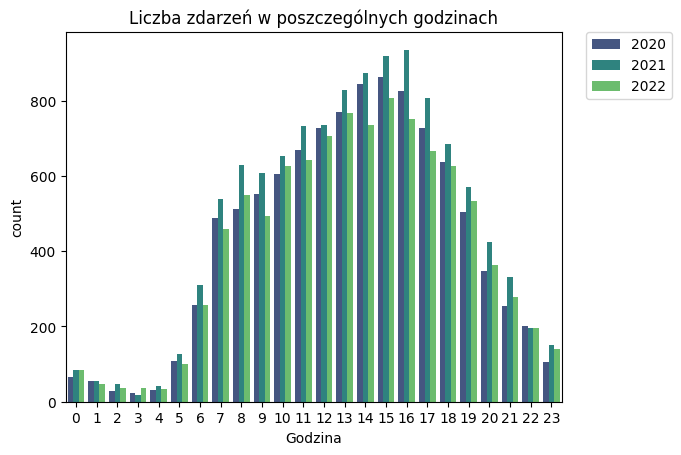

In [51]:
sns.countplot(x='Godzina',data=dane,hue= 'Rok', palette='viridis').set(title='Liczba zdarzeń w poszczególnych godzinach')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

[Text(0.5, 1.0, 'Liczba zdarzeń w poszczególnych miesiącach')]

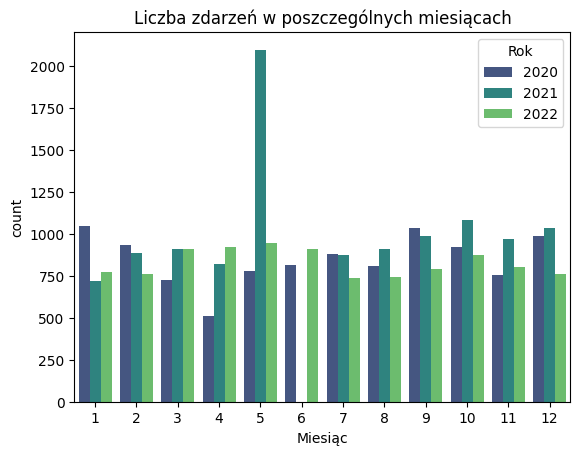

In [52]:
sns.countplot(x='Miesiąc',data=dane, hue='Rok', palette='viridis').set(title='Liczba zdarzeń w poszczególnych miesiącach')

In [53]:
Rocznie = dane.groupby('Rok').count()
Rocznie.head()

Id  Adres  Miejsce zdarzenia  Rodzaj zdarzenia  Data zdarzenia  \
Rok                                                                       
2020  10194  10194              10194             10194           10194   
2021  11290  11291              11291             11291           11291   
2022   9935   9935               9935              9935            9935   

      Współrzędne geograficzne  Warunki pogodowe  Obrażenia  \
Rok                                                           
2020                     10194             10194      10194   
2021                     11291             11291      11291   
2022                      9935              9935       9935   

      Długość geograficzna  Szerokość geograficzna  Godzina  Miesiąc  \
Rok                                                                    
2020                 10194                   10194    10194    10194   
2021                 11291                   11291    11291    11291   
2022                  9935                    9935     9935     9935   

      Dzień tygodnia  Osiedle  Wypadek  Wypadek śmiertelny  
Rok                                                         
2020           10194    10194    10194               10194  
2021           11291    11291    11291               11291  
2022            9935     9935     9935                9935

[None]

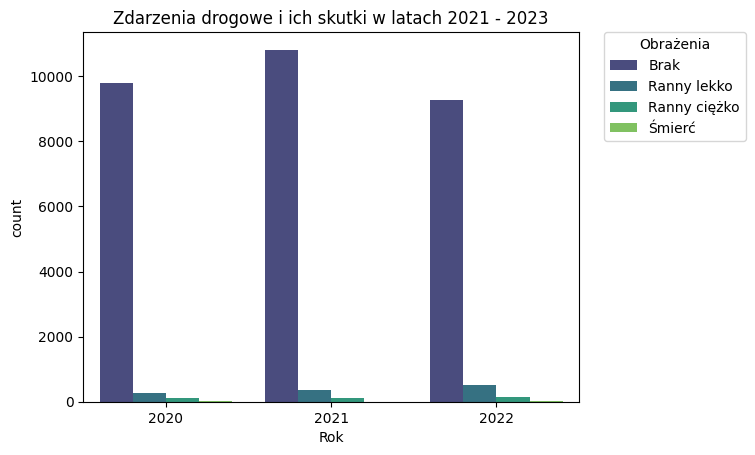

In [54]:
sns.countplot(x='Rok', hue= 'Obrażenia', data=dane,palette='viridis').set(title='Zdarzenia drogowe i ich skutki w latach 2021 - 2023')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.).set(title='Obrażenia')

[Text(0, 0, 'Najechanie na pojazd unieruchomiony'),
 Text(1, 0, 'Zderzenie pojazdów tylne'),
 Text(2, 0, 'Najechanie na pieszego'),
 Text(3, 0, 'Zderzenie pojazdów boczne'),
 Text(4, 0, 'Najechanie na słup, znak'),
 Text(5, 0, 'Najechanie na zwierzę'),
 Text(6, 0, 'Inne'),
 Text(7, 0, 'Najechanie na dziurę, wybój, garb'),
 Text(8, 0, 'Zderzenie pojazdów czołowe'),
 Text(9, 0, 'Wypadek z pasażerem'),
 Text(10, 0, 'Wywrócenie się pojazdu'),
 Text(11, 0, 'Najechanie na barierę ochronną'),
 Text(12, 0, 'Najechanie na zapore kolejową'),
 Text(13, 0, 'Najechanie na drzewo'),
 Text(14, 0, 'Zdarzenie z osobą UWR')]

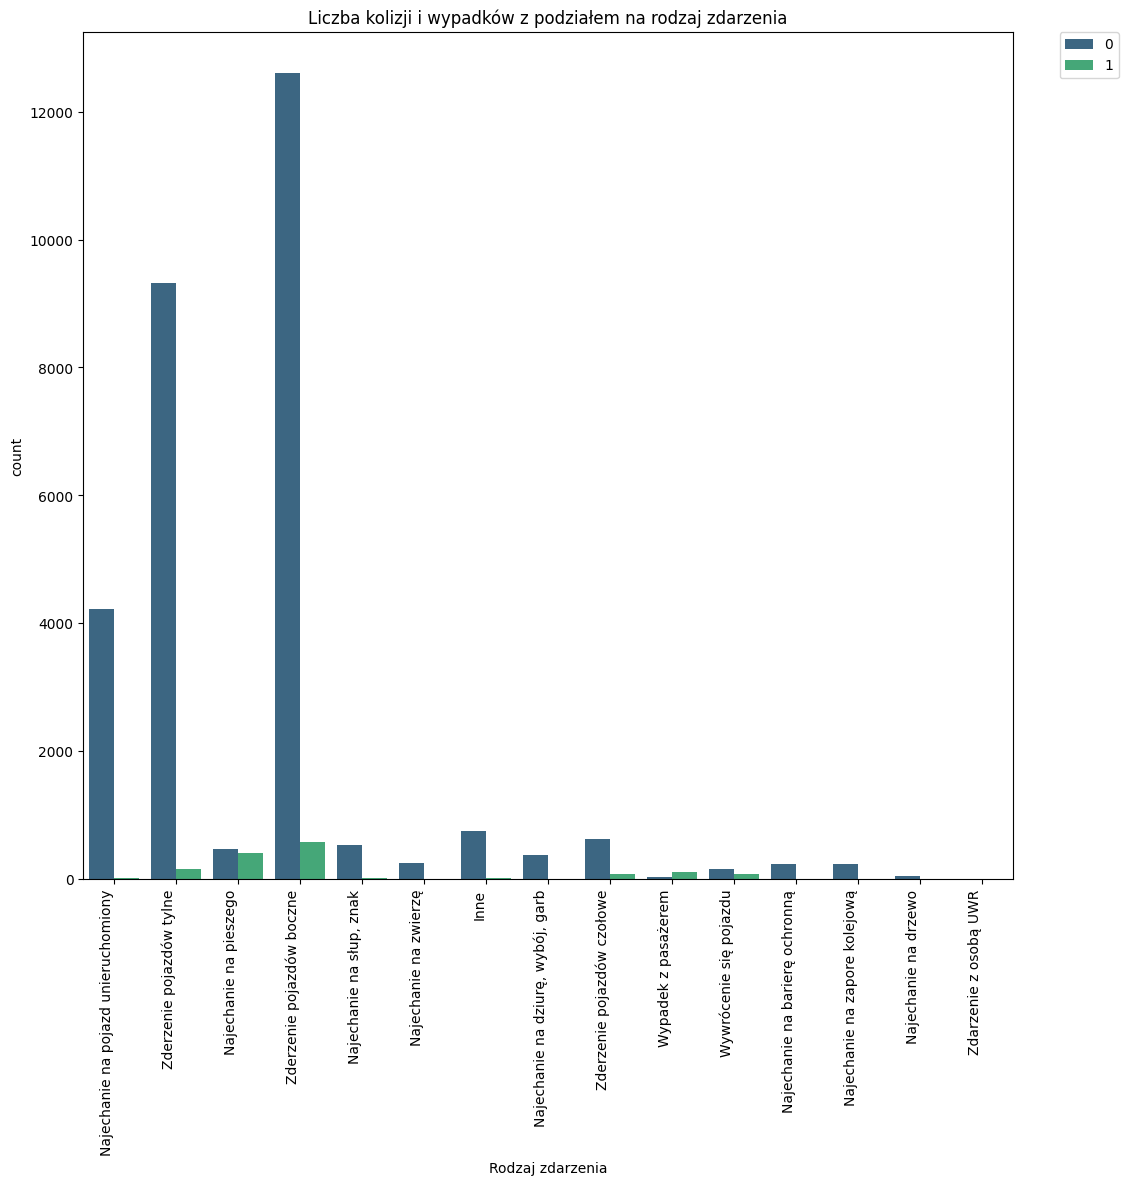

In [55]:
plt.figure(figsize=(12,11))
rz = sns.countplot(x='Rodzaj zdarzenia',data=dane,hue= 'Wypadek', palette='viridis')
rz.set(title='Liczba kolizji i wypadków z podziałem na rodzaj zdarzenia')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
rz.set_xticklabels(rz.get_xticklabels(), rotation=90, ha="right")

[Text(0, 0, 'Jezdnia'),
 Text(1, 0, 'Pobocze'),
 Text(2, 0, 'Chodnik, droga dla pieszych'),
 Text(3, 0, 'Parking, plac, MOP'),
 Text(4, 0, 'Przejazd tramwajowy, torowisko'),
 Text(5, 0, 'Przejście dla pieszych'),
 Text(6, 0, 'Pas dzielący jezdnie'),
 Text(7, 0, 'Wjazd, wyjazd z posesji, pola'),
 Text(8, 0, 'Przejazd dla rowerzystów'),
 Text(9, 0, 'Most, wiadukt, łącznica, tunel'),
 Text(10, 0, 'Droga, pas ruchu, śluza dla rowerów'),
 Text(11, 0, 'Przewiązka na drodze dwujezdniowej'),
 Text(12, 0, 'Przejazd kolejowy strzeżony'),
 Text(13, 0, 'Skarpa, rów'),
 Text(14, 0, 'Przystanek komunikacji publicznej'),
 Text(15, 0, 'Roboty drogowe, oznakowanie tymczasowe'),
 Text(16, 0, 'Przejazd kolejowy niestrzeżony')]

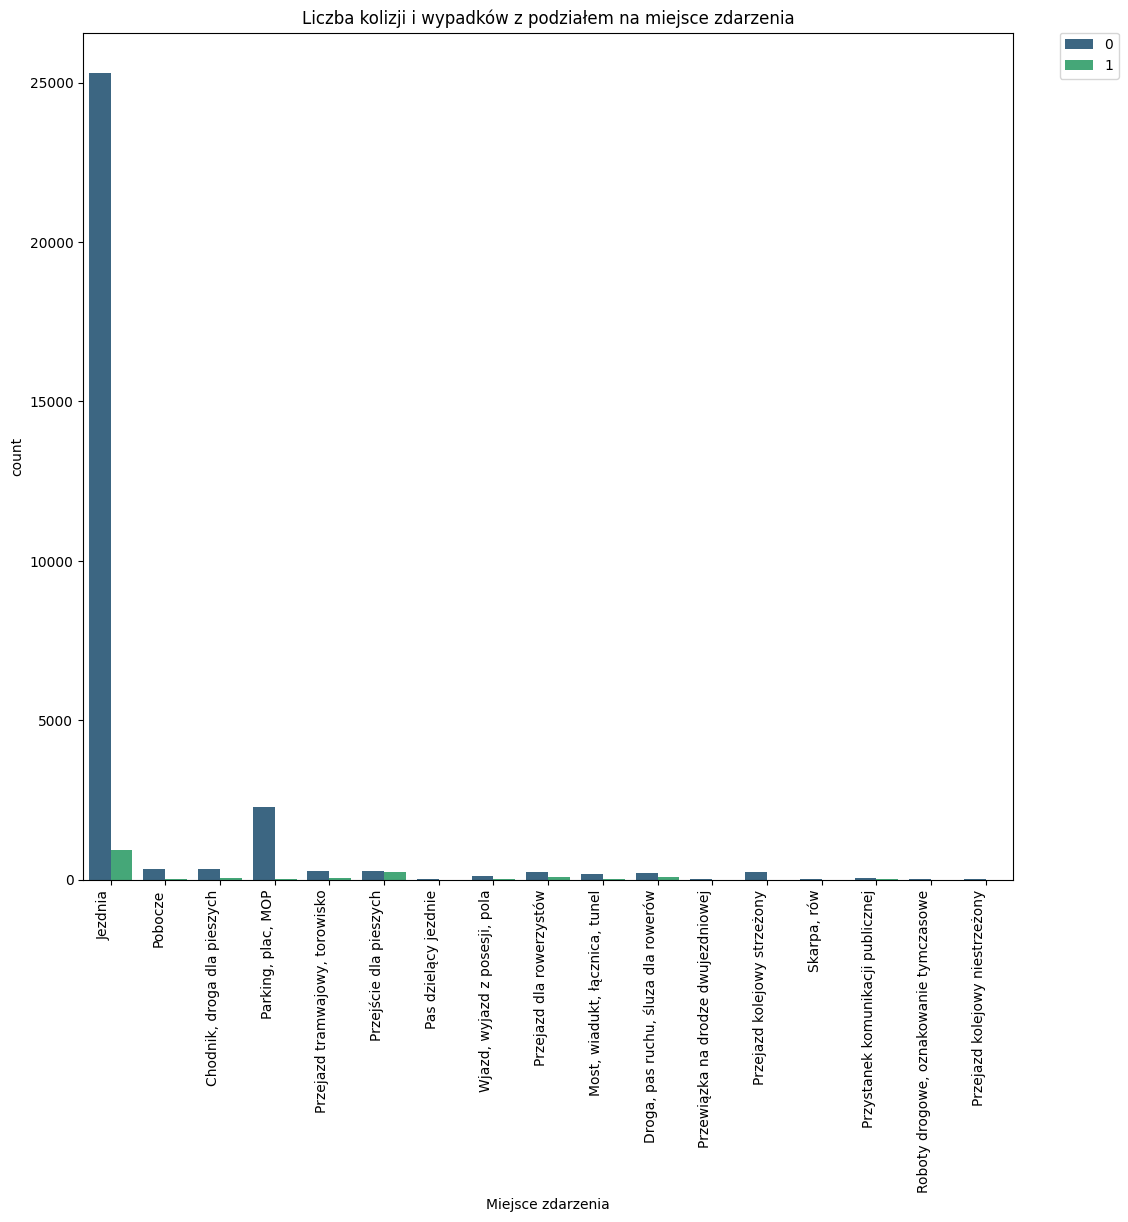

In [56]:
plt.figure(figsize=(12,11))
mz = sns.countplot(x='Miejsce zdarzenia',data=dane,hue= 'Wypadek', palette='viridis')
mz.set(title='Liczba kolizji i wypadków z podziałem na miejsce zdarzenia')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
mz.set_xticklabels(mz.get_xticklabels(), rotation=90, ha="right")

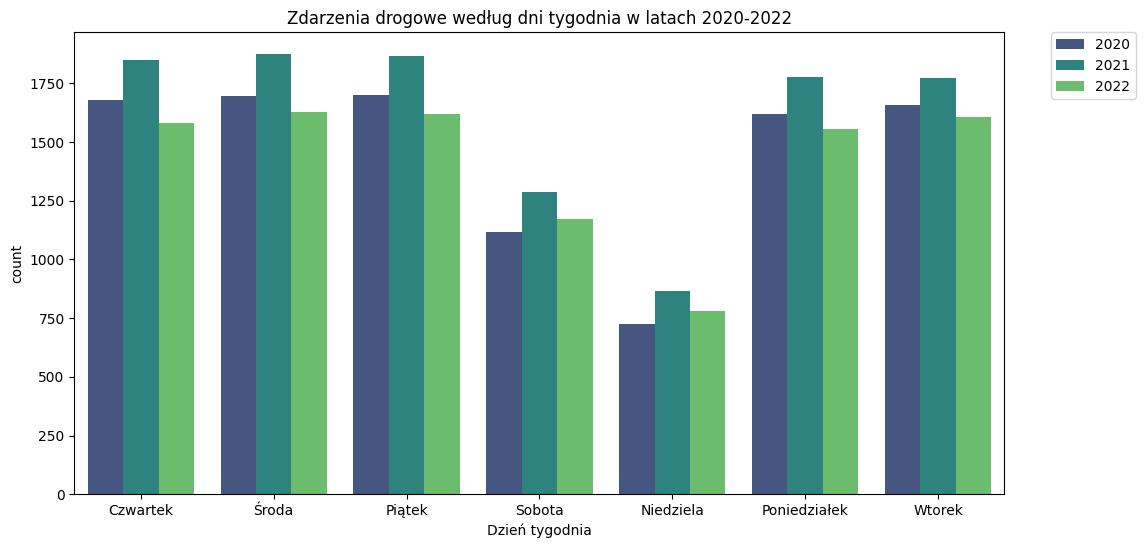

In [57]:
plt.figure(figsize=(12,6))
sns.countplot(x='Dzień tygodnia', hue='Rok', data=dane,palette='viridis').set(title='Zdarzenia drogowe według dni tygodnia w latach 2020-2022')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [58]:
dg = dane.groupby(by=['Dzień tygodnia','Godzina']).count()['Warunki pogodowe'].unstack()
dg.head()

Godzina         0   1   2   3   4   5    6    7    8    9   ...   14   15  \
Dzień tygodnia                                              ...             
Czwartek        34  17  17  11  13  44  154  288  294  273  ...  420  371   
Niedziela       46  31  33  22  23  26   29   22   46   78  ...  189  175   
Piątek          34  22   7   6  19  58  131  251  283  271  ...  416  444   
Poniedziałek    24  15  13  11  13  61  140  266  284  309  ...  401  469   
Sobota          61  43  32  22  18  33   38   63  116  172  ...  280  264   

Godzina          16   17   18   19   20   21   22  23  
Dzień tygodnia                                         
Czwartek        413  379  326  262  190  131   88  55  
Niedziela       189  170  201  156  124   97   52  45  
Piątek          423  331  317  255  171  127  113  79  
Poniedziałek    422  347  280  258  136  139   65  49  
Sobota          241  229  225  189  129  121   93  79  

[5 rows x 24 columns]

<Axes: xlabel='Godzina', ylabel='Dzień tygodnia'>

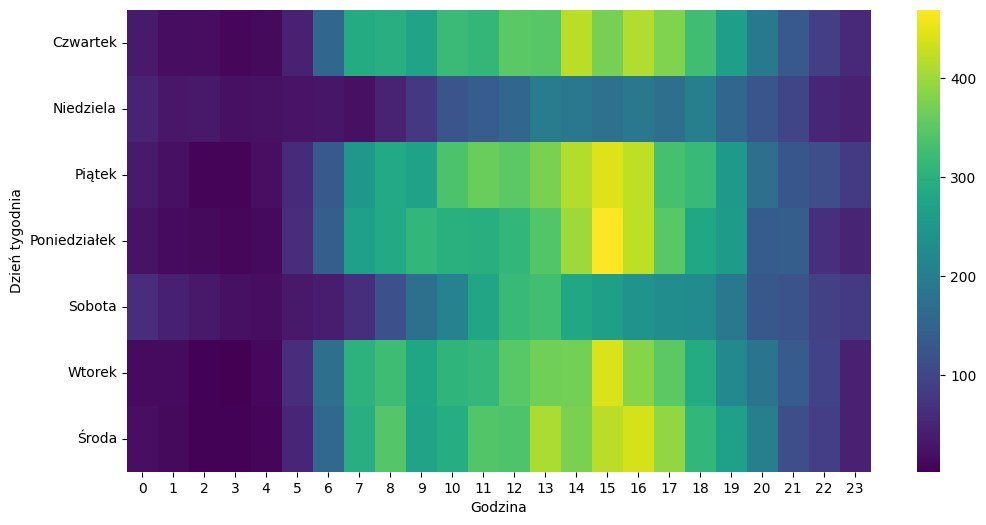

In [59]:
plt.figure(figsize=(12,6))
sns.heatmap(dg,cmap='viridis')

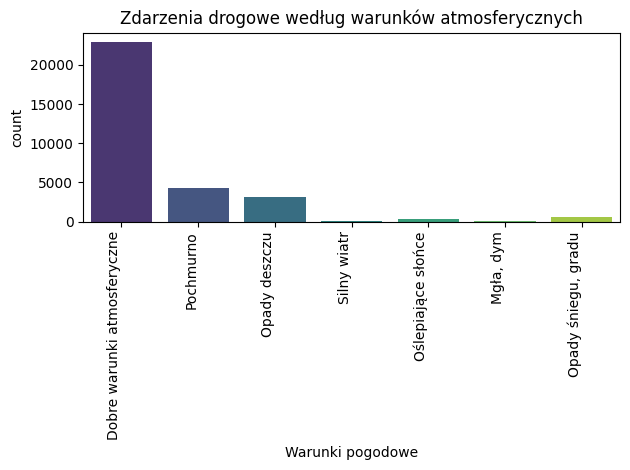

In [60]:
ax = sns.countplot(x='Warunki pogodowe',data=dane,palette='viridis')
ax.set(title='Zdarzenia drogowe według warunków atmosferycznych')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [61]:
Dzielnice = dane.groupby('Osiedle', as_index=False)['Wypadek'].count()

In [62]:
Dzielnice.sort_values('Wypadek', ascending=False)

Osiedle  Wypadek
36                         Przedmieście Świdnickie     2165
35                           Przedmieście Oławskie     1985
11                             Karłowice - Różanka     1957
39                                    Stare Miasto     1701
23                                        Nadodrze     1624
33                             Powstańców Śląskich     1517
8                                             Huby     1493
41                                        Szczepin     1368
7                            Gądów - Popowice Płd.     1363
2                                            Borek     1353
18                                         Leśnica     1214
27                                           Ołbin     1140
30              Pilczyce - Kozanów - Popowice Płn.     1088
15                              Krzyki - Partynice     1064
37                           Psie Pole - Zawidawie      975
31                                Plac Grunwaldzki      954
21                                   Muchobór Mały      943
22                                 Muchobór Wielki      871
6                          Grabiszyn - Grabiszynek      488
45                  Zacisze - Zalesie - Szczytniki      469
1        Biskupin - Sępolno - Dąbie - Bartoszowice      460
40                 Strachocin - Swojczyce - Wojnów      431
20                                         Maślice      399
9                                          Jagodno      347
4                                              Gaj      338
25                                          Oporów      307
42                                        Tarnogaj      282
13                                        Kleczków      274
5                                         Gajowice      243
26                              Osobowice - Rędzin      227
12                                         Klecina      226
44                                        Wojszyce      226
16                                          Księże      225
14                                          Kowale      184
17                                         Kuźniki      175
24                                       Nowy Dwór      171
28                                        Ołtaszyn      150
3                                          Brochów      145
32                 Polanowice - Poświętne - Ligota      139
38                                     Sołtysowice      124
34                               Pracze Odrzańskie      120
43                                          Widawa      109
47                                         Żerniki      107
10  Jerzmanowo - Jarnołtów - Strachowice - Osiniec      106
19                                 Lipa Piotrowska       91
46                                        Świniary       41
29                                       Pawłowice       36
0                                       Bieńkowice        5

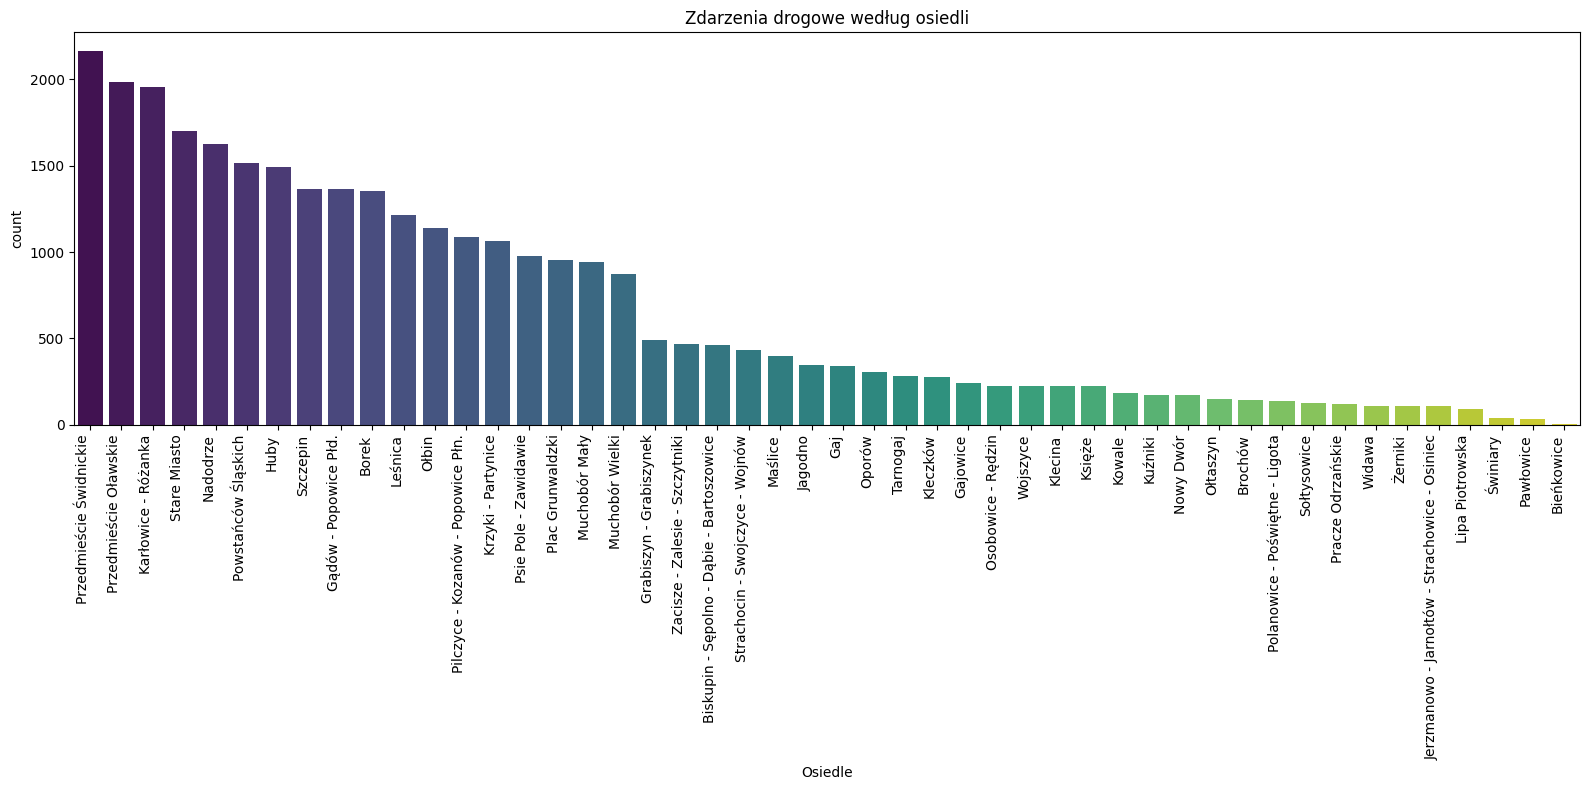

In [63]:
plt.figure(figsize=(16,8))
dziel = sns.countplot(x='Osiedle',data=dane,palette='viridis', order = dane['Osiedle'].value_counts().index)
dziel.set_xticklabels(dziel.get_xticklabels(), rotation=90, ha="right")
dziel.set(title='Zdarzenia drogowe według osiedli')
plt.tight_layout()
plt.show()

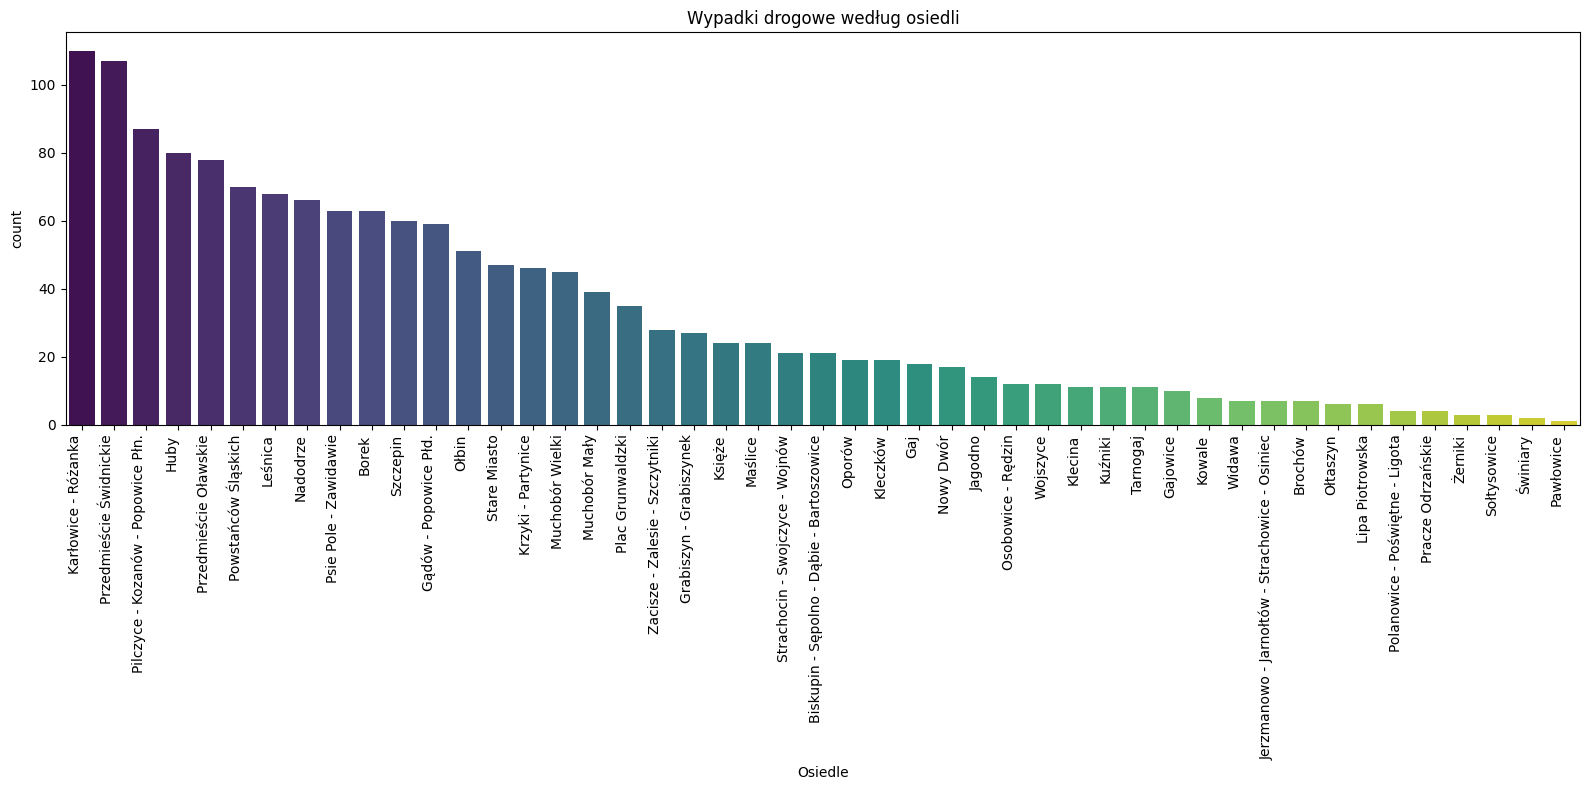

In [64]:
plt.figure(figsize=(16,8))
dzielwyp = sns.countplot(x='Osiedle',data=danewypadki,palette='viridis', order = danewypadki['Osiedle'].value_counts().index)
dzielwyp.set_xticklabels(dzielwyp.get_xticklabels(), rotation=90, ha="right")
dzielwyp.set(title='Wypadki drogowe według osiedli')
plt.tight_layout()
plt.show()

In [65]:
Dzielnice.rename(columns={'Osiedle':'NAZWAOSIED'}, inplace = True)  

[Text(0.5, 1.0, 'Mapa osiedli Wrocławia')]

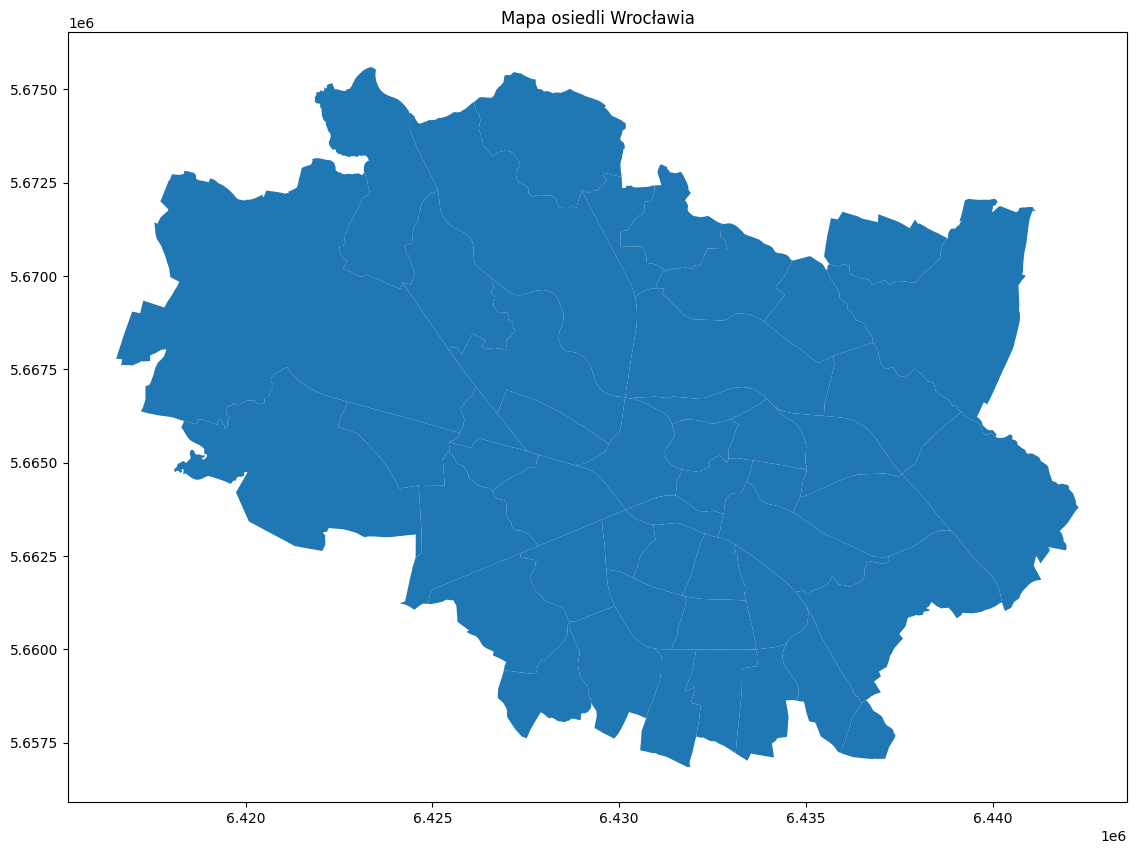

In [66]:
m = mapa_dzielnic.plot(figsize=(15, 10))
m.set(title='Mapa osiedli Wrocławia')

In [67]:
mapa_dzielnic.head()

OBJECTID  NROSIEDLA             NAZWAOSIED        DATA    SHAPE_AREA  \
0       340         21     Krzyki - Partynice  2016-01-21  5.254965e+06   
1       341         24  Gądów - Popowice Płd.  2016-01-21  3.134569e+06   
2       348         42            Sołtysowice  2016-01-21  4.547041e+06   
3       349         18             Bieńkowice  2016-01-21  1.433161e+06   
4       351         32                Żerniki  2016-01-21  3.908726e+06   

     SHAPE_LEN                                           geometry  
0  9994.583078  POLYGON ((6430117.675 5660766.234, 6430140.266...  
1  7588.647951  POLYGON ((6429726.139 5665488.426, 6429713.546...  
2  9003.773230  POLYGON ((6435263.203 5670431.681, 6435329.046...  
3  4760.314072  POLYGON ((6437233.661 5657388.908, 6437126.750...  
4  9132.805421  POLYGON ((6425733.868 5665795.775, 6425733.316...

In [68]:
dzielnice_zdarzenia = pd.merge(mapa_dzielnic, Dzielnice, on ='NAZWAOSIED', how ='left')

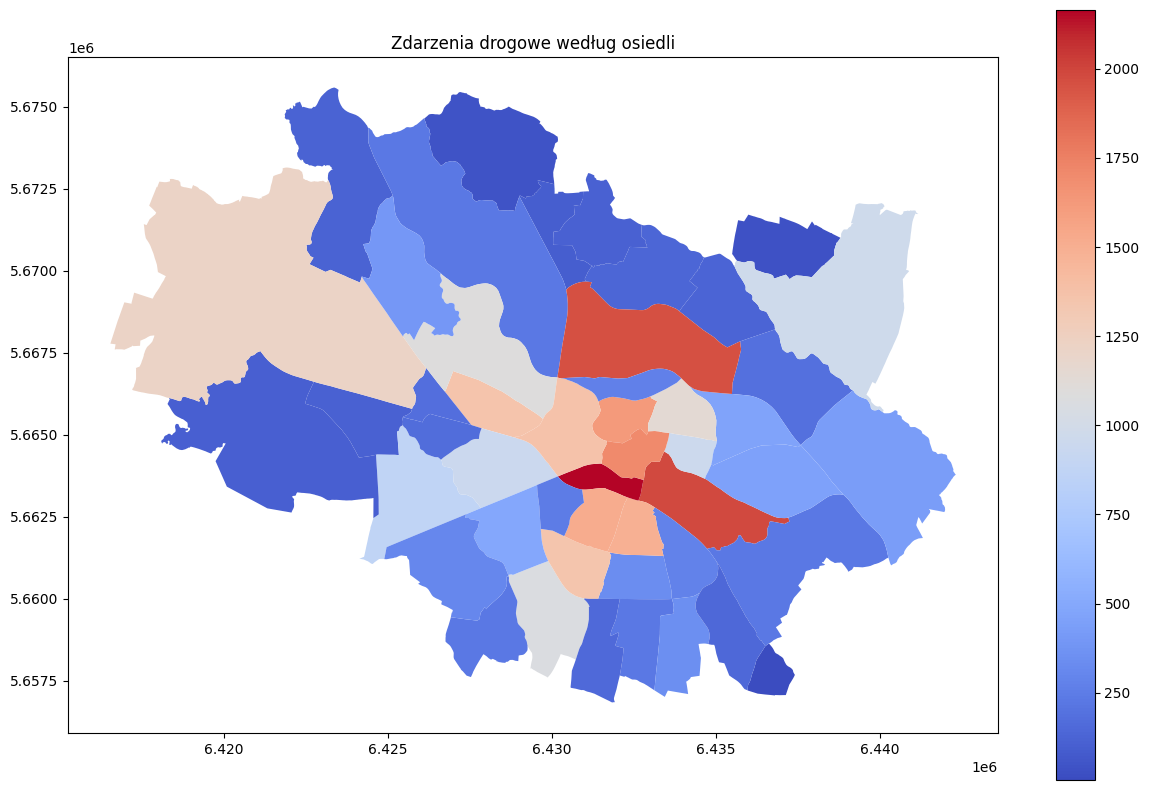

In [69]:
dzielnice_zdarzenia.plot(column='Wypadek', cmap='coolwarm', legend=True, figsize=(15, 10)).set(title='Zdarzenia drogowe według osiedli')
plt.axis('on')
plt.show()

[Text(0.5, 1.0, 'Rozkład kolizji i wypadków we Wrocławiu')]

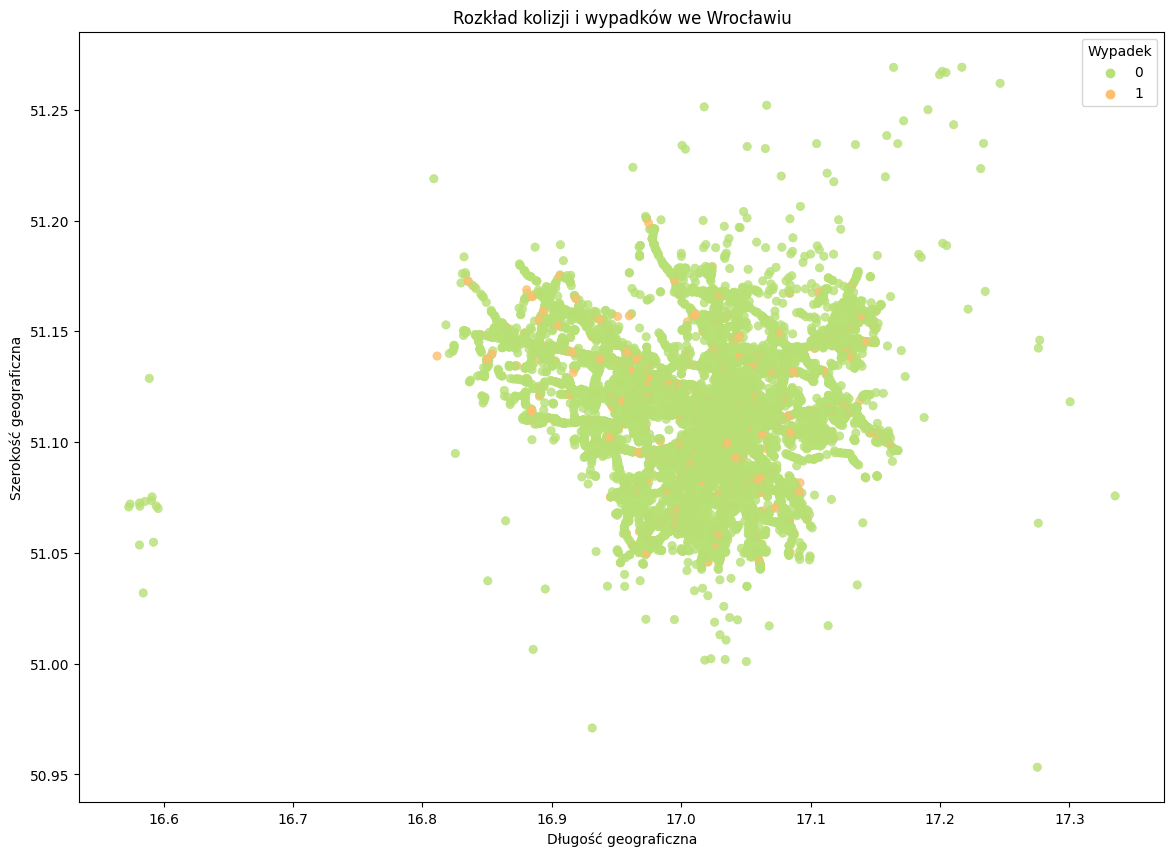

In [70]:
plt.figure(figsize=(14,10))
roz = sns.scatterplot(x='Długość geograficzna', y='Szerokość geograficzna',data=dane, hue='Wypadek',palette= 'RdYlGn_r',edgecolor=None,alpha=0.8)
roz.set(title='Rozkład kolizji i wypadków we Wrocławiu')

In [71]:
dummies = pd.get_dummies(dane[['Miejsce zdarzenia', 'Rodzaj zdarzenia','Warunki pogodowe', 'Osiedle']], dtype=np.float64, drop_first=True)
dane = dane.drop(['Miejsce zdarzenia', 'Rodzaj zdarzenia','Warunki pogodowe','Osiedle'],axis=1)
dane = pd.concat([dane,dummies],axis=1)

In [72]:
dmap = {'Poniedziałek':1,'Wtorek':2,'Środa':3,'Czwartek':4,'Piątek':5,'Sobota':6,'Niedziela':7}
dane['Dzień tygodnia'] = dane['Dzień tygodnia'].map(dmap)

In [73]:
dane['Godzina'] = dane['Godzina'].astype('float64')
dane['Miesiąc'] = dane['Miesiąc'].astype('float64')
dane['Dzień tygodnia'] = dane['Dzień tygodnia'].astype('float64')
dane = dane.drop(['Id', 'Adres', 'Data zdarzenia', 'Współrzędne geograficzne', 'Rok', 'Wypadek śmiertelny', 'Obrażenia'],axis=1)

In [74]:
dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31420 entries, 0 to 31419
Data columns (total 89 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Długość geograficzna                                      31420 non-null  float64
 1   Szerokość geograficzna                                    31420 non-null  float64
 2   Godzina                                                   31420 non-null  float64
 3   Miesiąc                                                   31420 non-null  float64
 4   Dzień tygodnia                                            31420 non-null  float64
 5   Wypadek                                                   31420 non-null  int64  
 6   Miejsce zdarzenia_Droga, pas ruchu, śluza dla rowerów     31420 non-null  float64
 7   Miejsce zdarzenia_Jezdnia                                 31420 non-null  float64
 8   Miejsce zdarzeni

In [75]:
dane.describe()

Długość geograficzna  Szerokość geograficzna       Godzina  \
count          31420.000000            31420.000000  31420.000000   
mean              17.021135               51.109484     13.486092   
std                0.052268                0.025788      4.622759   
min               16.573110               50.953280      0.000000   
25%               16.996572               51.093410     10.000000   
50%               17.028420               51.109440     14.000000   
75%               17.049190               51.124730     17.000000   
max               17.335330               51.269200     23.000000   

            Miesiąc  Dzień tygodnia       Wypadek  \
count  31420.000000    31420.000000  31420.000000   
mean       6.563908        3.660312      0.048727   
std        3.467117        1.846211      0.215300   
min        1.000000        1.000000      0.000000   
25%        4.000000        2.000000      0.000000   
50%        7.000000        4.000000      0.000000   
75%       10.000000        5.000000      0.000000   
max       12.000000        7.000000      1.000000   

       Miejsce zdarzenia_Droga, pas ruchu, śluza dla rowerów  \
count                                       31420.000000       
mean                                            0.009644       
std                                             0.097728       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             0.000000       
max                                             1.000000       

       Miejsce zdarzenia_Jezdnia  \
count               31420.000000   
mean                    0.835073   
std                     0.371120   
min                     0.000000   
25%                     1.000000   
50%                     1.000000   
75%                     1.000000   
max                     1.000000   

       Miejsce zdarzenia_Most, wiadukt, łącznica, tunel  \
count                                      31420.000000   
mean                                           0.005792   
std                                            0.075889   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            1.000000   

       Miejsce zdarzenia_Parking, plac, MOP  ...  Osiedle_Sołtysowice  \
count                          31420.000000  ...         31420.000000   
mean                               0.072724  ...             0.003947   
std                                0.259688  ...             0.062698   
min                                0.000000  ...             0.000000   
25%                                0.000000  ...             0.000000   
50%                                0.000000  ...             0.000000   
75%                                0.000000  ...             0.000000   
max                                1.000000  ...             1.000000   

       Osiedle_Stare Miasto  Osiedle_Strachocin - Swojczyce - Wojnów  \
count          31420.000000                             31420.000000   
mean               0.054137                                 0.013717   
std                0.226292                                 0.116317   
min                0.000000                                 0.000000   
25%                0.000000                                 0.000000   
50%                0.000000                                 0.000000   
75%                0.000000                                 0.000000   
max                1.000000                                 1.000000   

       Osiedle_Szczepin  Osiedle_Tarnogaj  Osiedle_Widawa  Osiedle_Wojszyce  \
count      31420.000000      31420.000000    31420.000000      31420.000000   
mean    

# **Korelacja między zmiennymi**

Nie ma silnej korelacji między rodzajem zdarzenia (wypadek lub kolizja), a pozostałymi zmiennymi.


<Axes: >

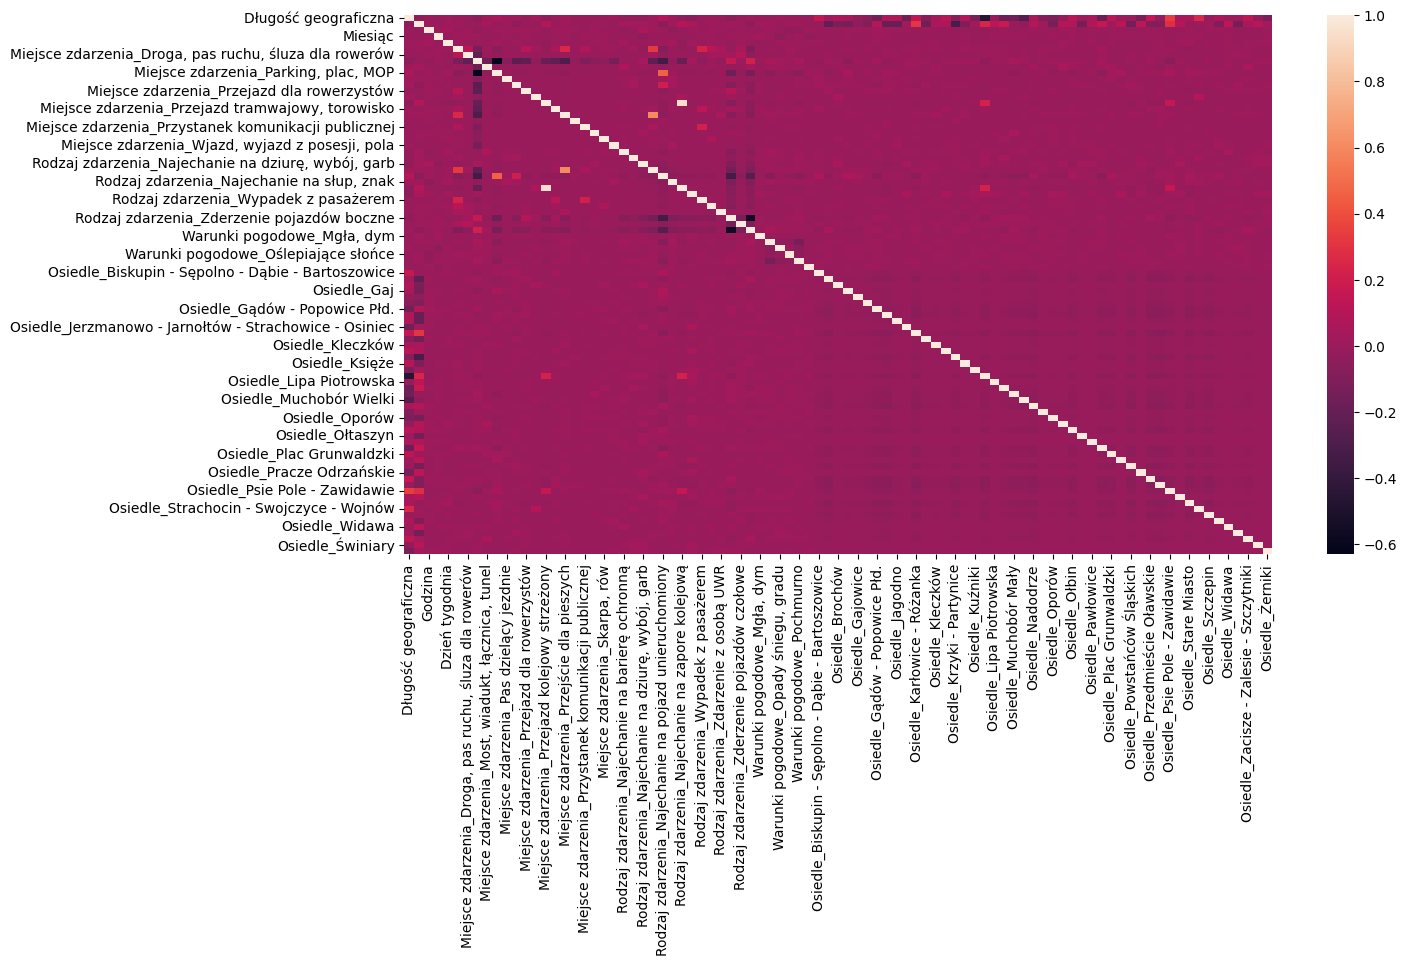

In [76]:
plt.figure(figsize=(14,7))
sns.heatmap(dane.corr())

In [77]:
column_to_move = dane.pop("Wypadek")
dane.insert(0, "Wypadek", column_to_move)

In [78]:
dane.corr()['Wypadek'].sort_values()

Miejsce zdarzenia_Jezdnia                              -0.138819
Rodzaj zdarzenia_Zderzenie pojazdów tylne              -0.096029
Rodzaj zdarzenia_Najechanie na pojazd unieruchomiony   -0.082061
Miejsce zdarzenia_Parking, plac, MOP                   -0.054843
Rodzaj zdarzenia_Najechanie na dziurę, wybój, garb     -0.025108
                                                          ...   
Rodzaj zdarzenia_Wywrócenie się pojazdu                 0.118662
Rodzaj zdarzenia_Wypadek z pasażerem                    0.231591
Miejsce zdarzenia_Przejście dla pieszych                0.257602
Rodzaj zdarzenia_Najechanie na pieszego                 0.328695
Wypadek                                                 1.000000
Name: Wypadek, Length: 89, dtype: float64

[Text(0.5, 1.0, 'Rozkład korelacji')]

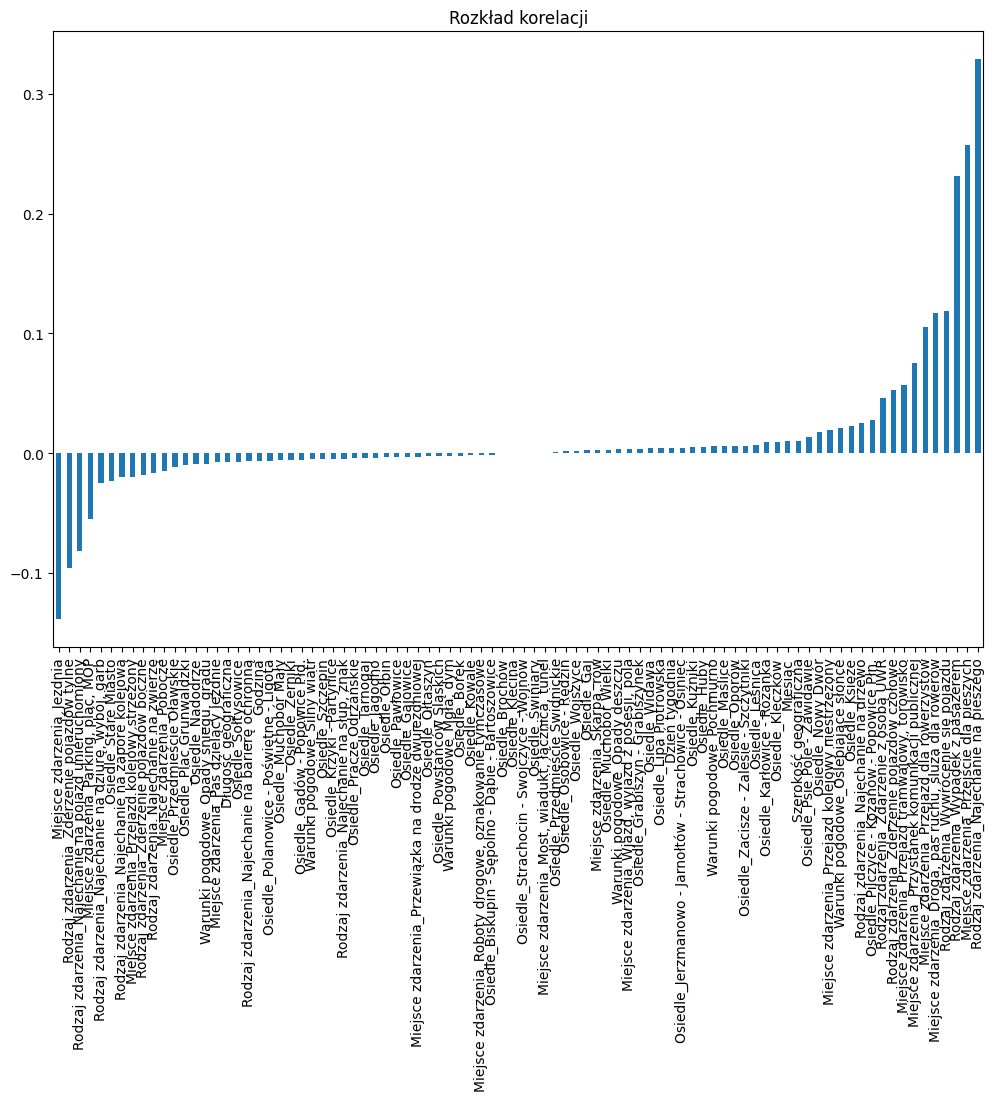

In [79]:
dane.corr()['Wypadek'][1:].sort_values().plot(kind='bar', figsize=(12,8)).set(title='Rozkład korelacji')

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics


## **Podział danych na zbiór treningowy i testowy**

In [81]:
X = dane.drop('Wypadek',axis=1)
y = dane['Wypadek']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## **Standaryzacja danych**

In [82]:
scaler = StandardScaler()

In [83]:
X_train = scaler.fit_transform(X_train)

In [84]:
X_test = scaler.transform(X_test)

## **Budowanie struktury sieci neuronowej i szkolenie modelu**

In [85]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [86]:
X.shape

(31420, 88)

In [87]:
model = Sequential()


model.add(Dense(88, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(44, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(units=1,activation='sigmoid'))


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, 
                                                      label_smoothing=0.2), 
                                                      optimizer='adam')

In [88]:
model.fit(x=X_train, 
          y=y_train,
          batch_size = 100, 
          epochs=600,
          validation_split = 0.2,
          callbacks=[early_stop])

Epoch 1/600
176/176 [==============================] - 2s 4ms/step - loss: 0.5141 - val_loss: 0.3912
Epoch 2/600
176/176 [==============================] - 0s 3ms/step - loss: 0.4363 - val_loss: 0.3860
Epoch 3/600
176/176 [==============================] - 0s 3ms/step - loss: 0.4173 - val_loss: 0.3829
Epoch 4/600
176/176 [==============================] - 0s 3ms/step - loss: 0.4127 - val_loss: 0.3808
Epoch 5/600
176/176 [==============================] - 0s 3ms/step - loss: 0.4062 - val_loss: 0.3807
Epoch 6/600
176/176 [==============================] - 0s 3ms/step - loss: 0.4021 - val_loss: 0.3809
Epoch 7/600
176/176 [==============================] - 0s 3ms/step - loss: 0.3996 - val_loss: 0.3809
Epoch 8/600
176/176 [==============================] - 0s 3ms/step - loss: 0.3980 - val_loss: 0.3788
Epoch 9/600
176/176 [==============================] - 0s 3ms/step - loss: 0.3963 - val_loss: 0.3794
Epoch 10/600
176/176 [==============================] - 0s 3ms/step - loss: 0.3943 - val_lo

In [89]:
losses = pd.DataFrame(model.history.history)

<Axes: >

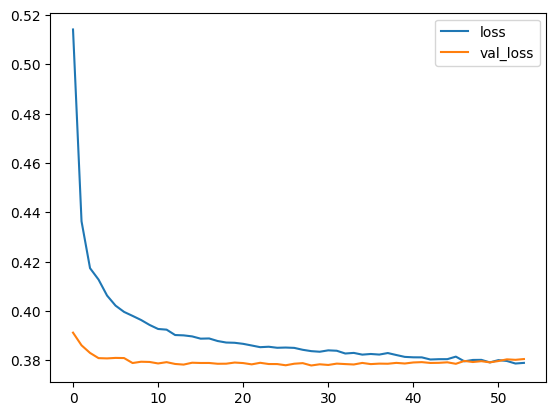

In [90]:
losses[['loss','val_loss']].plot()

In [91]:
predictions1 = (model.predict(X_test) > 0.5).astype('int64')

295/295 [==============================] - 0s 1ms/step


In [92]:
print(classification_report(y_test,predictions1))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8954
           1       0.56      0.18      0.27       472

    accuracy                           0.95      9426
   macro avg       0.76      0.59      0.62      9426
weighted avg       0.94      0.95      0.94      9426



In [93]:
confusion_matrix(y_test,predictions1)

array([[8887,   67],
       [ 388,   84]])

In [94]:
dane.Wypadek.value_counts()

0    29889
1     1531
Name: Wypadek, dtype: int64

In [95]:
negatywne, pozytywne = np.bincount(dane['Wypadek'])
total = negatywne + pozytywne
print('Zdarzenia:\n    Suma: {}\n    Pozytywne: {} ({:.2f}% sumy zdarzeń)\n'.format(
    total, pozytywne, 100 * pozytywne / total))

Zdarzenia:
    Suma: 31420
    Pozytywne: 1531 (4.87% sumy zdarzeń)



Ze względu na silnie niezbalansowany zbiór danych, pomimo wyskiej dokładności, duża część przypadków z klasy mniejszości została sklasyfikowana jako fałszywie negatywna. Aby 
zwiększyć klasyfikację True Positive oraz False Positive (która mimo, że niepożądana, jest mniej krytyczna) zmodyfikowano threshold. Wyznaczono krzywą ROC, a następnie dobrano na jej podstawie threshold, dający najlepszy stosunek czułości do swoistości.

In [96]:
predictions = model.predict(X_test)
pred_1= predictions > 0.1
pred_2= predictions > 0.2
pred_3= predictions > 0.3
pred_4= predictions > 0.4
pred_5= predictions > 0.5
pred_6= predictions > 0.6
pred_7= predictions > 0.7
pred_8= predictions > 0.8
pred_9= predictions > 0.9

295/295 [==============================] - 0s 1ms/step


In [97]:
fpr1, tpr1, _ = metrics.roc_curve(y_test,  pred_1)
fpr2, tpr2, _ = metrics.roc_curve(y_test,  pred_2)
fpr3, tpr3, _ = metrics.roc_curve(y_test,  pred_3)
fpr4, tpr4, _ = metrics.roc_curve(y_test,  pred_4)
fpr5, tpr5, _ = metrics.roc_curve(y_test,  pred_4)
fpr6, tpr6, _ = metrics.roc_curve(y_test,  pred_6)
fpr7, tpr7, _ = metrics.roc_curve(y_test,  pred_7)
fpr8, tpr8, _ = metrics.roc_curve(y_test,  pred_8)
fpr9, tpr9, _ = metrics.roc_curve(y_test,  pred_9)

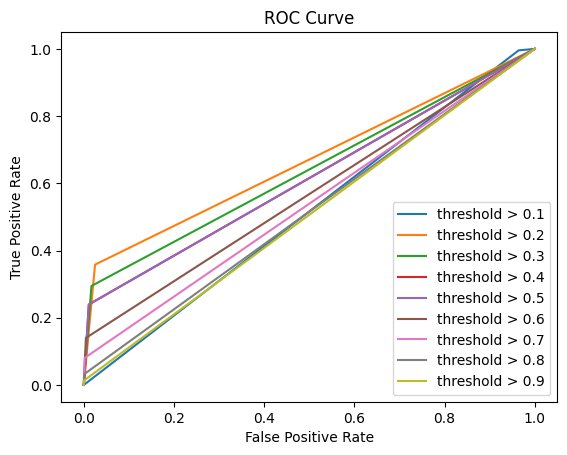

In [98]:
plt.plot(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, fpr4, tpr4, fpr5, tpr5, fpr6, tpr6, fpr7, tpr7, fpr8, tpr8, fpr9, tpr9)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend(['threshold > 0.1','threshold > 0.2', 'threshold > 0.3', 'threshold > 0.4', 'threshold > 0.5', 'threshold > 0.6', 'threshold > 0.7', 'threshold > 0.8', 'threshold > 0.9'])
plt.show()

In [99]:
predictions2 = (model.predict(X_test) > 0.2).astype('int64')

295/295 [==============================] - 0s 1ms/step


In [100]:
print(classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8954
           1       0.43      0.36      0.39       472

    accuracy                           0.94      9426
   macro avg       0.70      0.67      0.68      9426
weighted avg       0.94      0.94      0.94      9426



In [101]:
confusion_matrix(y_test,predictions2)

array([[8731,  223],
       [ 303,  169]])

## **Wnioski**

Zmiana thresholdu z 0.5 na 0.2 spowodowała zwiększenie klasyfikacji jako True Positive o ok. 60%, natomiast zmniejszyła klasyfikację jako False Negative o ok. 20%.